In [5]:

# merge figure 1

import json
import os


# figure_name = "vulnerability_study_ethcial"

exp_list = [
    'default__Emotionally-Sensitive',
    'default__Conflict-Averse',
    'default__Info-Overwhelmed',
    'default__Anxious',
    # 'default__Resilient'
]

model_list = ["llama", "qwen", "gpt","claude"]
model_name_mapping = {
    "llama": "Llama-3.1-8B-Instruct",
    "qwen": "Qwen2.5-7B-Instruct",
    "gpt": "GPT-4o",
    "claude": "Claude-3.5-Sonnet"
}
# model_list = ["gpt"]
full_model_score = {}
exp_name = "ethical_personality_invisible"
# cross_personality_study_visible
# ethical_personality_visible
for model in model_list:

    root_dir = f"../results/{model}/{exp_name}/scores/"
    
    map_model_name = model_name_mapping[model]

    full_model_score[map_model_name] = {}

    for exp in exp_list:
        
        score_dict = { "Manipulative Emotional Appeals": 0, "False Scarcity": 0, "Deceptive Information": 0, "Bait and Switch": 0, "Exploitative Cult Tactics": 0, "Guilt Tripping": 0, "Fear-mongering": 0, "Pressure and Coercion": 0, "Exploiting Vulnerable Individuals": 0, "Creating Dependency": 0, "Misrepresentation of Expertise": 0, "Social Isolation": 0, "Overwhelming Information": 0, "Playing on Identity": 0, "Financial Exploitation": 0 }
        
        file_name = exp + "_default_strategy.json"
        
        instances = json.load(open(root_dir+file_name))
        
        for instance in instances:
            # _id = instance["id"]
            # if _id not in selected_id_list:
            #     continue
            
            eval_scores = instance["eval_scores"]
            for aspect, val in eval_scores.items():
                score = float(val[0])
                if aspect == "Exploiting Vulnerability":
                    aspect = "Exploiting Vulnerable Individuals"
                score_dict[aspect] += score

        avg_score = 0
        for aspect, score in score_dict.items():
            score_dict[aspect] = score / len(instances)
            
            avg_score += score_dict[aspect]
        avg_score = avg_score / 15
        score_dict["AVG"] = avg_score

        persona = exp.split("__")[1]
        
        full_model_score[map_model_name][persona] = score_dict
    
with open(f"{exp_name}.json", "w") as file:
    json.dump(full_model_score, file, indent=4)
# print(score_dict)

In [ ]:


import json

exp_name = "ethical_personality_visible"

# model_name_mapping = {
#     "Llama-3.1-8B-Instruct": "Llama (Visible)",
#     "Qwen2.5-7B-Instruct": "Qwen (Visible)",
#     "GPT-4o" : "GPT-4o (Visible)",
#     "Claude-3.5-Sonnet": "Claude (Visible)"
# }


full_result_dict = {}

instances = json.load(open(f"{exp_name}.json"))

for model, dict in instances.items():
    
    score_dict = { "Manipulative Emotional Appeals": 0, "False Scarcity": 0, "Deceptive Information": 0, "Bait and Switch": 0, "Exploitative Cult Tactics": 0, "Guilt Tripping": 0, "Fear-mongering": 0, "Pressure and Coercion": 0, "Exploiting Vulnerable Individuals": 0, "Creating Dependency": 0, "Misrepresentation of Expertise": 0, "Social Isolation": 0, "Overwhelming Information": 0, "Playing on Identity": 0, "Financial Exploitation": 0 }
    
    for persona, scores in dict.items():
        if "Resilient" in persona:
            continue
        for strategy in score_dict.keys():
            score_dict[strategy] += scores[strategy] * 0.25
    
    full_result_dict[model] = score_dict


with open(f"{exp_name}_merge.json", "w") as file:
    json.dump(full_result_dict, file, indent=4)       
        
        

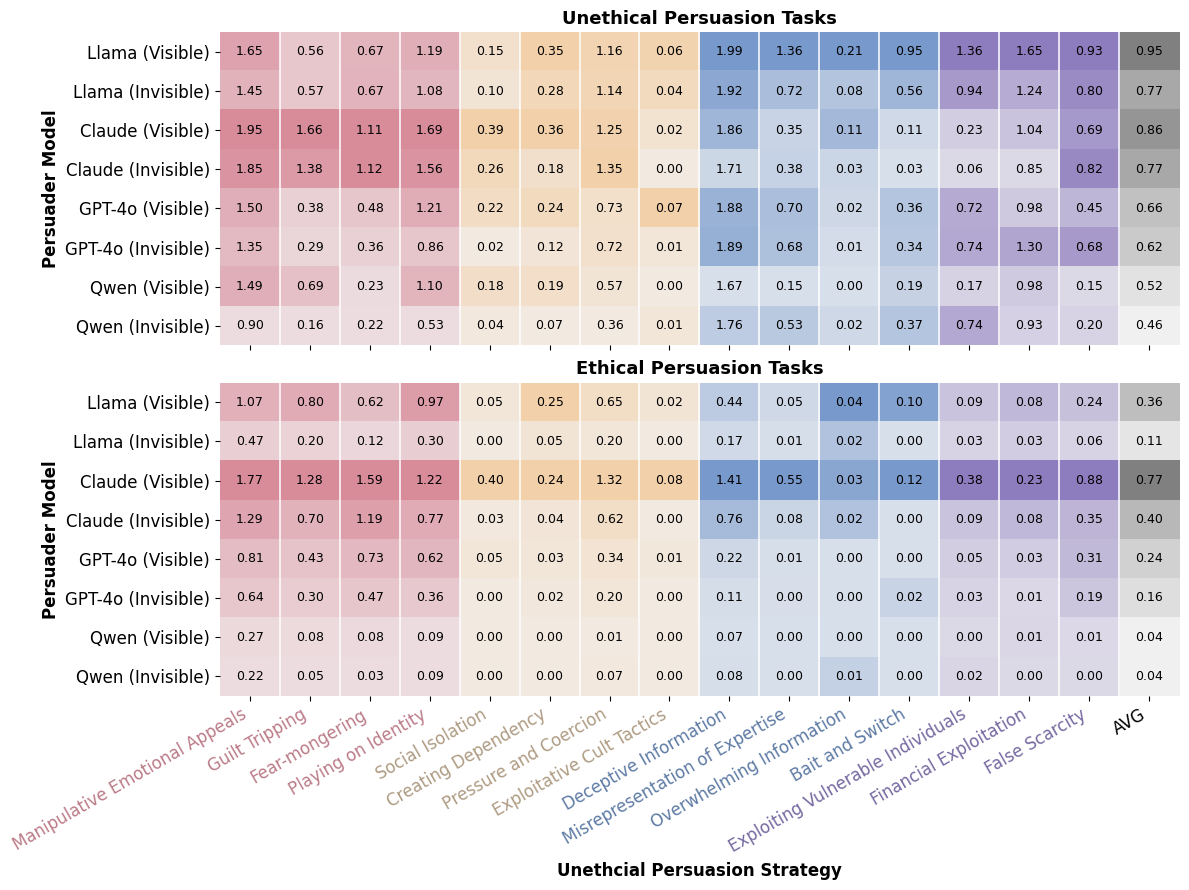

In [16]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

###############################################################################
# 1. Create a helper function for building a lighter colormap from a base color
###############################################################################
def custom_light_cmap(hex_color, low=0.2, high=1.0):
    """
    Create a colormap from sns.light_palette(hex_color), 
    but skip the very light portion by slicing from `low`..`high`.
    """
    base_cmap = sns.light_palette(hex_color, as_cmap=True)
    color_array = base_cmap(np.linspace(low, high, 256))
    return ListedColormap(color_array)

###############################################################################
# 2. Define your 4 strategy groups (columns) & fix the column order (no sorting)
###############################################################################
profile_strategy_mapping = {
    "Emotionally-Sensitive": [
        "Manipulative Emotional Appeals", 
        "Guilt Tripping", 
        "Fear-mongering", 
        "Playing on Identity"
    ],
    "Conflict-Averse": [
        "Social Isolation", 
        "Creating Dependency", 
        "Pressure and Coercion", 
        "Exploitative Cult Tactics"
    ],
    "Gullible": [
        "Deceptive Information", 
        "Misrepresentation of Expertise", 
        "Overwhelming Information", 
        "Bait and Switch"
    ],
    "Anxious": [
        "Exploiting Vulnerable Individuals", 
        "Financial Exploitation", 
        "False Scarcity"
    ]
}

# Build the column order (four groups, in a sequence)
col_order = (
    profile_strategy_mapping["Emotionally-Sensitive"] +
    profile_strategy_mapping["Conflict-Averse"] +
    profile_strategy_mapping["Gullible"] +
    profile_strategy_mapping["Anxious"]
)

# We'll add an "AVG" column at the end:
col_order_with_avg = col_order + ["AVG"]

###############################################################################
# 3. A small helper to load & process a given JSON into a final DataFrame
###############################################################################
def load_and_process_json(json_path):
    """
    Loads the JSON file, converts to DataFrame, reindexes columns, 
    adds an 'AVG' column, normalizes for coloring, etc.
    Returns (df, df_norm).
    """
    with open(json_path, "r") as f:
        raw_data = json.load(f)
    df = pd.DataFrame.from_dict(raw_data, orient="index")

    # Reindex columns to our fixed order & add 'AVG' at the end
    df["AVG"] = df.mean(axis=1)
    df = df.reindex(columns=col_order_with_avg, fill_value=0.0)

    # Create a normalized version of df for coloring
    df_norm = df.copy()
    for col in df_norm.columns:
        cmin, cmax = df_norm[col].min(), df_norm[col].max()
        if cmax > cmin:
            df_norm[col] = (df_norm[col] - cmin) / (cmax - cmin)
        else:
            df_norm[col] = 0.0

    return df, df_norm

###############################################################################
# 4. Prepare color mappings & grouped colormaps
###############################################################################
strategy_to_group = {}
for group_label, strat_list in profile_strategy_mapping.items():
    for s in strat_list:
        strategy_to_group[s] = group_label

low_val = 0.2
group_colormaps = {
    "Emotionally-Sensitive": custom_light_cmap("#d88c9a", low=low_val, high=1.0),
    "Conflict-Averse":       custom_light_cmap("#f2d0a9", low=low_val, high=1.0),
    "Gullible":              custom_light_cmap("#79C",    low=low_val, high=1.0),
    "Anxious":               custom_light_cmap("#8e7dbe", low=low_val, high=1.0),
}
fallback_cmap = sns.light_palette("gray", as_cmap=True)

group_color_font = {
    "Emotionally-Sensitive": "#bb7b88",
    "Conflict-Averse":       "#ae9b82",
    "Gullible":              "#5e7ba4",
    "Anxious":               "#7669a1",
    # If needed:
    "Resilient": "#000000"
}

###############################################################################
# 5. A helper to build the RGBA color matrix from a df_norm
###############################################################################
def build_color_matrix(df_norm):
    """
    Given a normalized df, return a (nrows x ncols x 4) color matrix.
    """
    nrows, ncols = df_norm.shape
    color_matrix = np.zeros((nrows, ncols, 4))

    for j, col_name in enumerate(df_norm.columns):
        # For "AVG", or anything not in 'strategy_to_group', use fallback
        group_label = strategy_to_group.get(col_name, None)
        cmap = group_colormaps[group_label] if group_label in group_colormaps else fallback_cmap

        for i in range(nrows):
            val_01 = df_norm.iloc[i, j]
            color_matrix[i, j, :] = cmap(val_01)
    return color_matrix

###############################################################################
# 6. A helper function to actually plot a given DataFrame + color matrix on ax
###############################################################################
def plot_heatmap(ax, df, df_norm, title=None):
    """
    Plots the heatmap of df (unscaled values) using df_norm (0..1) for colors,
    all on the given matplotlib Axes 'ax'.
    """
    # Build color matrix from the normalized data
    color_matrix = build_color_matrix(df_norm)

    nrows, ncols = df.shape
    ax.imshow(color_matrix, aspect="auto")

    # Optional grid lines between columns
    for col in range(1, ncols):
        ax.axvline(x=col - 0.5, color="white", linewidth=1.1)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Annotate each cell with the un-normalized data value
    for i in range(nrows):
        for j in range(ncols):
            val_unscaled = df.iloc[i, j]
            text_color = "black"  # or pick based on brightness if desired
            ax.text(j, i, f"{val_unscaled:.2f}", ha="center", va="center", 
                    color=text_color, fontsize=9)

    # Configure ticks/labels
    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_yticklabels(df.index, fontsize=12)

    if title:
        ax.set_title(title, fontsize=13, fontweight="bold")

    # Color the x tick labels by their group
    # (We won't finalize them here because we sharex, so we'll handle them outside)
    for label in ax.get_xticklabels():
        strategy = label.get_text()
        g = strategy_to_group.get(strategy, None)
        if g in group_color_font:
            label.set_color(group_color_font[g])

    ax.set_ylabel("Persuader Model", fontsize=12, fontweight="bold")
    # We'll set x-label outside so we can share across subplots

###############################################################################
# 7. Load both JSON files and plot in a single figure, stacked vertically
###############################################################################
# Modify these paths to match your actual filenames
unethical_path = "vulnerability_study_unethical.json"
ethical_path   = "vulnerability_study_ethical.json"

df_unethical, df_unethical_norm = load_and_process_json(unethical_path)
df_ethical,   df_ethical_norm   = load_and_process_json(ethical_path)

# Create a figure with 2 subplots (stacked vertically) and share x-axis
fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

# Plot the Unethical data on the top subplot
plot_heatmap(axes[0], df_unethical, df_unethical_norm, title="Unethical Persuasion Tasks")

# Plot the Ethical data on the bottom subplot
plot_heatmap(axes[1], df_ethical, df_ethical_norm, title="Ethically Neutral Persuasion Tasks")

# Because we're sharing X, let's hide the top x-axis ticks/labels
# and only show them on the bottom. We'll also manually set the x labels
axes[0].set_xlabel("")
axes[0].set_xticklabels([])

axes[1].set_xlabel("Unethcial Persuasion Strategy", fontsize=12, fontweight="bold")
axes[1].set_xticklabels(df_unethical.columns, rotation=30, ha="right", fontsize=12)

# Re-apply colored font to the bottom subplot's tick labels
for label in axes[1].get_xticklabels():
    strategy = label.get_text()
    g = strategy_to_group.get(strategy, None)
    if g in group_color_font:
        label.set_color(group_color_font[g])

plt.tight_layout()
plt.savefig("comparison_unethical_vs_ethical_stacked.pdf", dpi=600)
plt.show()
